# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# %matplotlib inline 
# %matplotlib notebook

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_Root_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/"
# MODEL_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
import skimage as sk
sk.__version__

In [2]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

In [3]:
# tf.compat.v1.disable_eager_execution()

## Configurations

In [1]:
class SpotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "simul_spots"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_SHAPE=1024
    
#     IMAGE_RESIZE_MODE = "crop"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512#512#128
    IMAGE_MAX_DIM = 512#512#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32*2

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
#     IMAGE_MIN_SCALE=0
#     USE_MINI_MASK = False
#     n_clusters=5
    
    FPN_CLASSIF_FC_LAYERS_SIZE=1024;
    
config = SpotsConfig()
config.display()

MODEL_DIR = MODEL_Root_DIR + config.NAME

NameError: name 'Config' is not defined

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import matthews_corrcoef
print(normalized_mutual_info_score([1, 1, 0, 0], [0, 0, 1, 1]).astype('float32'))
print(matthews_corrcoef([1, 1, 0, 0], [0, 0, 1, 1]))

1.0
-1.0


In [3]:
# import sklearn
# sklearn.metrics.consensus_score(A, B)

In [4]:
A=[1, 4, 0, 0]
B=[1, 5, 0, 0]
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('hamming')
X = [A,B]
dist.pairwise(X)[0,1]

0.25

In [44]:
dist.pairwise(X)

array([[0. , 0.5],
       [0.5, 0. ]])

In [10]:
a = np.array([1,2,3])
my_dict = {1:23, 2:34, 3:36, 4:45}
np.vectorize(my_dict.get)(a)


array([23, 34, 36])

In [42]:
dist.dist_to_rdist(X)

[[1, 2, 0, 0], [0, 0, 0, 0]]

In [31]:
matthews_corrcoef([1, 2, 0, 0], [0, 0, 0, 0])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class SpotsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("spots", 1, "A")
        self.add_class("spots", 2, "T")
        self.add_class("spots", 3, "G")
        self.add_class("spots", 4, "C")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
#             print(shapes)
            self.add_image("spots", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, spots=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        image=self.add_noise(image)
#         print(info)
#         print(info['spots'])
        for shape, color, dims in info['spots']:            
            image = self.draw_shape(image, "circle", dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "spots":
            return info["spots"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['spots']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['spots']):
#             shape2="circle"
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        shape="circle"
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
#             print("color",color)
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s), 45, 0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["A", "T", "C", "G"])
#         shape = random.choice(["square", "circle"])
        # Color
#         color = tuple([random.randint(0, 255) for _ in range(3)])
        if shape == "A":
            color=tuple([0,0,255])#blue
        elif shape == "T":
            color=tuple([0,255,0])#green
        elif shape == "C":
            color=tuple([255,0,255])#magneta
        elif shape == "G":
            color=tuple([255,255,0])#yellow

#         print("here",color)
        # Center x, y
        buffer = 10
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
#         print(buffer, int(height//20))
#         s = random.randint(buffer, 20)
        s = random.randint(4, 5)
#         print(s)
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
#         bg_color = np.array([random.randint(0, 255) for _ in range(3)])
#         bg_color =np.array([0,0,0])
        bg_color = np.array([random.randint(0, 4) for _ in range(3)])
#         print(bg_color.shape)
#         print(self.add_noise(bg_color))
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(80, 100)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
#         print(shapes)
        return bg_color, shapes
    
    def add_noise(self,image):
    #    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 100
        var = 100
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy

In [5]:
im_h, im_w= config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]
# im_h, im_w=512,512

# Training dataset
dataset_train = SpotsDataset()
dataset_train.load_shapes(500, im_h, im_w)
dataset_train.prepare()

# Validation dataset
dataset_val = SpotsDataset()
dataset_val.load_shapes(50, im_h, im_w)
dataset_val.prepare()

In [ ]:
# dataset_val.image_ids
# 1024//20
MODEL_DIR

In [79]:
# dataset_val.image_info

In [12]:
dataset_val.source_class_ids

{'': [0], 'spots': [0, 1, 2, 3, 4]}

In [13]:
dataset_train.class_from_source_map

{'.0': 0, 'spots.1': 1, 'spots.2': 2, 'spots.3': 3, 'spots.4': 4}

In [44]:
list(np.array([0,0,0]))==list(np.array([0,0,0]))

True

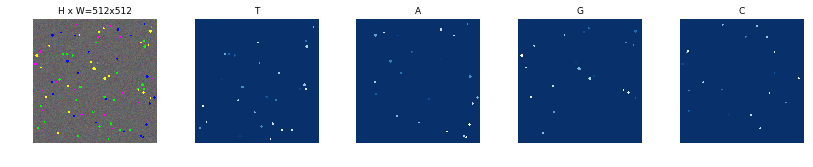

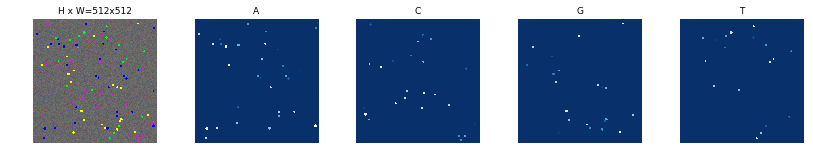

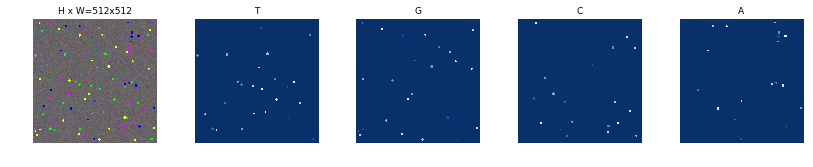

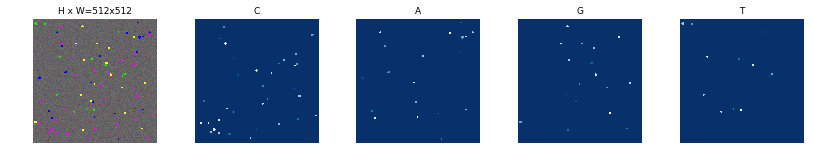

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(16, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 32, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (16, ?)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 32, 5), dtype=float32)
pred_class_ids (?, 32)
target_class_ids (?, 32)


In [7]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="clustering"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(16, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 64, 1024), dtype=float32)
mrcnn_class_logits2 Tensor("Slice:0", shape=(?, 64, 4), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer:0", shape=(?, 64), dtype=int64)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 64, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 64, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 64, 5), dtype=float32)
pred_class_ids (?, 64)
target_class_ids (?, 64)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 64, 5), dtype=float32)
pred_class_ids (?, 64)
target_class_ids (?, 64)


In [8]:
# # Create model in training mode
# config.head='def'
# config.assign_label_mode ="clustering"#"clustering","classification"
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)

In [29]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform([3,2,4,3,10]).shape

(5, 4)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [11]:
# Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
# dataset_train.

In [2]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


model.train(dataset_train, dataset_val, 
            learning_rate=lr ,#/ 10,
            epochs=100, 
            layers=layers_to_tune)

NameError: name 'modellib' is not defined

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

3. for "clustering" mode, change the learning rate to 1/10 of the one for classification.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,#/10, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/simul_spots20200618T1754/mask_rcnn_simul_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mas

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


[[1 2]
 [4 2]]
psudo labels [[1 2]
 [4 2]]
  1/100 [..............................] - ETA: 25:55:32 - loss: 9.5881 - rpn_class_loss: 2.1039 - rpn_bbox_loss: 1.4572 - mrcnn_class_loss: 3.7315 - mrcnn_bbox_loss: 1.0582 - mrcnn_mask_loss: 1.2373 - lambda_nmi: 0.9426[[1 2]
 [4 2]]
psudo labels [[1 2]
 [4 2]]
  2/100 [..............................] - ETA: 13:04:48 - loss: 9.0980 - rpn_class_loss: 2.0689 - rpn_bbox_loss: 1.4485 - mrcnn_class_loss: 3.3351 - mrcnn_bbox_loss: 1.0162 - mrcnn_mask_loss: 1.2293 - lambda_nmi: 0.9426[[1 2]
 [4 2]]
psudo labels [[1 2]
 [4 2]]
  3/100 [..............................] - ETA: 8:45:20 - loss: 8.3936 - rpn_class_loss: 2.0115 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 2.7804 - mrcnn_bbox_loss: 0.9552 - mrcnn_mask_loss: 1.2121 - lambda_nmi: 0.9426 [[1 3]
 [4 2]]
psudo labels [[1 3]
 [4 2]]
  4/100 [>.............................] - ETA: 6:37:08 - loss: 7.6980 - rpn_class_loss: 1.9293 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 2.2279 - mrcnn_bbox_loss: 0.

 53/100 [==============>...............] - ETA: 23:50 - loss: 2.7555 - rpn_class_loss: 0.2627 - rpn_bbox_loss: 0.4963 - mrcnn_class_loss: 0.7923 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.6932 - lambda_nmi: 0.6497[[  1  71]
 [  2 116]
 [  3  44]
 [  4 105]]
psudo labels [[ 1 90]
 [ 2 84]
 [ 3 97]
 [ 4 65]]
 54/100 [===============>..............] - ETA: 23:04 - loss: 2.7353 - rpn_class_loss: 0.2584 - rpn_bbox_loss: 0.4916 - mrcnn_class_loss: 0.7908 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.6888 - lambda_nmi: 0.6493[[  1  43]
 [  2 122]
 [  3  76]
 [  4  95]]
psudo labels [[  1  63]
 [  2 103]
 [  3  87]
 [  4  83]]
 55/100 [===============>..............] - ETA: 22:22 - loss: 2.7138 - rpn_class_loss: 0.2543 - rpn_bbox_loss: 0.4869 - mrcnn_class_loss: 0.7878 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.6844 - lambda_nmi: 0.6494[[  1  40]
 [  2 121]
 [  3 119]
 [  4  56]]
psudo labels [[ 1 80]
 [ 2 82]
 [ 3 80]
 [ 4 94]]
 56/100 [===============>..............] - ETA: 21:41 - 

psudo labels [[  1 128]
 [  2  73]
 [  3  61]
 [  4  74]]
  3/100 [..............................] - ETA: 12:37 - loss: 1.0884 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.5114 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2885 - lambda_nmi: 0.5980[[  1 120]
 [  2  62]
 [  3  66]
 [  4  88]]
psudo labels [[ 1 72]
 [ 2 82]
 [ 3 92]
 [ 4 90]]
  4/100 [>.............................] - ETA: 12:37 - loss: 1.1227 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.5509 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2845 - lambda_nmi: 0.5959[[  1 131]
 [  2  44]
 [  3  66]
 [  4  95]]
psudo labels [[  1  82]
 [  2  80]
 [  3  66]
 [  4 108]]
  5/100 [>.............................] - ETA: 12:55 - loss: 1.1221 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.5574 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2814 - lambda_nmi: 0.5954[[  1 112]
 [  2  60]
 [  3  57]
 [  4 107]]
psudo labels [[ 1 78]
 [ 2 76]
 [ 3 86]
 [ 4 96]

psudo labels [[  1  66]
 [  2 104]
 [  3  76]
 [  4  90]]
 29/100 [=======>......................] - ETA: 9:48 - loss: 1.0472 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1274 - mrcnn_class_loss: 0.5292 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2578 - lambda_nmi: 0.5982 [[  1 101]
 [  2  70]
 [  3  91]
 [  4  74]]
psudo labels [[  1 114]
 [  2  73]
 [  3  74]
 [  4  75]]
 30/100 [========>.....................] - ETA: 9:35 - loss: 1.0438 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.5275 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2569 - lambda_nmi: 0.5981[[ 1 78]
 [ 2 90]
 [ 3 74]
 [ 4 94]]
psudo labels [[ 1 95]
 [ 2 75]
 [ 3 87]
 [ 4 79]]
 31/100 [========>.....................] - ETA: 9:25 - loss: 1.0448 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.5302 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2558 - lambda_nmi: 0.5982[[  1  92]
 [  2 108]
 [  3  61]
 [  4  75]]
psudo labels [[  1 106]
 [  2  66]
 [  3  70]
 [  4  94]]


 55/100 [===============>..............] - ETA: 5:11 - loss: 0.9905 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.4990 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2453 - lambda_nmi: 0.5967[[  1  72]
 [  2  96]
 [  3 132]
 [  4  36]]
psudo labels [[  1 112]
 [  2  68]
 [  3  90]
 [  4  66]]
 56/100 [===============>..............] - ETA: 5:02 - loss: 0.9883 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.4978 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2449 - lambda_nmi: 0.5966[[  1  60]
 [  2  87]
 [  3 158]
 [  4  31]]
psudo labels [[  1 104]
 [  2  93]
 [  3  75]
 [  4  64]]
 57/100 [================>.............] - ETA: 4:54 - loss: 0.9872 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.4979 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2445 - lambda_nmi: 0.5965[[  1  94]
 [  2  79]
 [  3 135]
 [  4  28]]
psudo labels [[  1 105]
 [  2  77]
 [  3  85]
 [  4  69]]
 58/100 [================>.............] - 

  5/100 [>.............................] - ETA: 7:06 - loss: 0.8802 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.4806 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.2095 - lambda_nmi: 0.5980[[  1 114]
 [  2  71]
 [  3  79]
 [  4  72]]
psudo labels [[  1  95]
 [  2  57]
 [  3 102]
 [  4  82]]
  6/100 [>.............................] - ETA: 7:11 - loss: 0.8590 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.4622 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.2076 - lambda_nmi: 0.5973[[  1 112]
 [  2  80]
 [  3  82]
 [  4  62]]
psudo labels [[ 1 96]
 [ 2 92]
 [ 3 86]
 [ 4 62]]
  7/100 [=>............................] - ETA: 7:02 - loss: 0.8503 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.2064 - lambda_nmi: 0.5963[[  1 109]
 [  2  92]
 [  3  87]
 [  4  48]]
psudo labels [[  1 103]
 [  2  87]
 [  3  76]
 [  4  70]]
  8/100 [=>............................] - ETA: 6:5

 57/100 [================>.............] - ETA: 3:18 - loss: 0.7640 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.3938 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1963 - lambda_nmi: 0.5906[[ 1 78]
 [ 2 82]
 [ 3 97]
 [ 4 79]]
psudo labels [[ 1 77]
 [ 2 83]
 [ 3 86]
 [ 4 90]]
 58/100 [================>.............] - ETA: 3:13 - loss: 0.7612 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.3916 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1961 - lambda_nmi: 0.5906[[ 1 77]
 [ 2 85]
 [ 3 94]
 [ 4 80]]
psudo labels [[ 1 84]
 [ 2 86]
 [ 3 80]
 [ 4 86]]
 59/100 [================>.............] - ETA: 3:08 - loss: 0.7589 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.3899 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1958 - lambda_nmi: 0.5905[[ 1 77]
 [ 2 87]
 [ 3 80]
 [ 4 92]]
psudo labels [[ 1 95]
 [ 2 95]
 [ 3 71]
 [ 4 75]]
 60/100 [=================>............] - ETA: 3:03 - loss: 0.7573 - rpn_class_loss: 0.010

  7/100 [=>............................] - ETA: 7:47 - loss: 0.5487 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1852 - lambda_nmi: 0.5880[[ 1 83]
 [ 2 67]
 [ 3 95]
 [ 4 91]]
psudo labels [[  1  62]
 [  2 102]
 [  3  82]
 [  4  90]]
  8/100 [=>............................] - ETA: 7:36 - loss: 0.5532 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.2280 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1838 - lambda_nmi: 0.5879[[  1  63]
 [  2  85]
 [  3 104]
 [  4  84]]
psudo labels [[ 1 91]
 [ 2 89]
 [ 3 83]
 [ 4 73]]
  9/100 [=>............................] - ETA: 7:36 - loss: 0.5674 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1823 - lambda_nmi: 0.5884[[  1  64]
 [  2  74]
 [  3 115]
 [  4  83]]
psudo labels [[ 1 75]
 [ 2 82]
 [ 3 94]
 [ 4 85]]
 10/100 [==>...........................] - ETA: 7:23 - loss: 0.5624

 59/100 [================>.............] - ETA: 3:21 - loss: 0.5651 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1755 - lambda_nmi: 0.5893[[  1  74]
 [  2 109]
 [  3  65]
 [  4  88]]
psudo labels [[  1 121]
 [  2  71]
 [  3  80]
 [  4  64]]
 60/100 [=================>............] - ETA: 3:17 - loss: 0.5671 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1755 - lambda_nmi: 0.5894[[  1  65]
 [  2 101]
 [  3  98]
 [  4  72]]
psudo labels [[  1  68]
 [  2  96]
 [  3 102]
 [  4  70]]
 61/100 [=================>............] - ETA: 3:12 - loss: 0.5662 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1752 - lambda_nmi: 0.5894[[  1  83]
 [  2  88]
 [  3 105]
 [  4  60]]
psudo labels [[  1  59]
 [  2  87]
 [  3 109]
 [  4  81]]
 62/100 [=================>............] - 

  9/100 [=>............................] - ETA: 7:04 - loss: 0.4722 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.2013 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1598 - lambda_nmi: 0.5873[[ 1 91]
 [ 2 91]
 [ 3 81]
 [ 4 73]]
psudo labels [[ 1 74]
 [ 2 89]
 [ 3 79]
 [ 4 94]]
 10/100 [==>...........................] - ETA: 7:02 - loss: 0.4782 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1604 - lambda_nmi: 0.5875[[ 1 97]
 [ 2 96]
 [ 3 54]
 [ 4 89]]
psudo labels [[ 1 84]
 [ 2 99]
 [ 3 79]
 [ 4 74]]
 11/100 [==>...........................] - ETA: 6:52 - loss: 0.4780 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1598 - lambda_nmi: 0.5880[[  1  68]
 [  2 117]
 [  3  67]
 [  4  84]]
psudo labels [[ 1 86]
 [ 2 91]
 [ 3 99]
 [ 4 60]]
 12/100 [==>...........................] - ETA: 6:47 - loss: 0.4833 - rpn_class_los

 61/100 [=================>............] - ETA: 3:07 - loss: 0.4769 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1616 - lambda_nmi: 0.5883[[ 1 84]
 [ 2 82]
 [ 3 78]
 [ 4 92]]
psudo labels [[ 1 78]
 [ 2 79]
 [ 3 94]
 [ 4 85]]
 62/100 [=================>............] - ETA: 3:03 - loss: 0.4764 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1617 - lambda_nmi: 0.5882[[  1 101]
 [  2  80]
 [  3  77]
 [  4  78]]
psudo labels [[  1 104]
 [  2  76]
 [  3  97]
 [  4  59]]
 63/100 [=================>............] - ETA: 2:57 - loss: 0.4763 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1617 - lambda_nmi: 0.5882[[  1  76]
 [  2  89]
 [  3 104]
 [  4  67]]
psudo labels [[  1  71]
 [  2  82]
 [  3 110]
 [  4  73]]
 64/100 [==================>...........] - ETA: 2:52 - loss

 11/100 [==>...........................] - ETA: 6:45 - loss: 0.5170 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1534 - lambda_nmi: 0.5891[[ 1 86]
 [ 2 77]
 [ 3 76]
 [ 4 97]]
psudo labels [[  1  87]
 [  2  71]
 [  3 101]
 [  4  77]]
 12/100 [==>...........................] - ETA: 6:49 - loss: 0.5119 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1533 - lambda_nmi: 0.5891[[ 1 95]
 [ 2 70]
 [ 3 72]
 [ 4 99]]
psudo labels [[ 1 87]
 [ 2 96]
 [ 3 81]
 [ 4 72]]
 13/100 [==>...........................] - ETA: 6:56 - loss: 0.5133 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1533 - lambda_nmi: 0.5890[[ 1 86]
 [ 2 77]
 [ 3 80]
 [ 4 93]]
psudo labels [[  1  76]
 [  2  63]
 [  3 111]
 [  4  86]]
 14/100 [===>..........................] - ETA: 6:59 - loss: 0.5078 - rpn_c

 63/100 [=================>............] - ETA: 2:56 - loss: 0.4910 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1530 - lambda_nmi: 0.5896[[  1  81]
 [  2  75]
 [  3  80]
 [  4 100]]
psudo labels [[ 1 81]
 [ 2 74]
 [ 3 85]
 [ 4 96]]
 64/100 [==================>...........] - ETA: 2:52 - loss: 0.4907 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1529 - lambda_nmi: 0.5896[[  1  74]
 [  2  72]
 [  3  82]
 [  4 108]]
psudo labels [[  1  67]
 [  2  68]
 [  3 120]
 [  4  81]]
 65/100 [==================>...........] - ETA: 2:47 - loss: 0.4900 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.1528 - lambda_nmi: 0.5896[[ 1 77]
 [ 2 76]
 [ 3 84]
 [ 4 99]]
psudo labels [[  1  59]
 [  2  86]
 [  3 117]
 [  4  74]]
 66/100 [==================>...........] - ETA: 2:43 - loss

 39/100 [==========>...................] - ETA: 4:45 - loss: 0.4678 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1498 - lambda_nmi: 0.5883[[  1  52]
 [  2  76]
 [  3 100]
 [  4 108]]
psudo labels [[  1  66]
 [  2  77]
 [  3  91]
 [  4 102]]
 40/100 [===========>..................] - ETA: 4:42 - loss: 0.4661 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1497 - lambda_nmi: 0.5883[[ 1 67]
 [ 2 80]
 [ 3 92]
 [ 4 97]]
psudo labels [[ 1 72]
 [ 2 73]
 [ 3 94]
 [ 4 97]]
 41/100 [===========>..................] - ETA: 4:37 - loss: 0.4648 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1498 - lambda_nmi: 0.5883[[ 1 75]
 [ 2 78]
 [ 3 90]
 [ 4 93]]
psudo labels [[ 1 81]
 [ 2 78]
 [ 3 95]
 [ 4 82]]
 42/100 [===========>..................] - ETA: 4:31 - loss: 0.4636 - rpn_c

 91/100 [==========================>...] - ETA: 43s - loss: 0.4769 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1491 - lambda_nmi: 0.5886[[ 1 94]
 [ 2 87]
 [ 3 71]
 [ 4 84]]
psudo labels [[  1  85]
 [  2  73]
 [  3 101]
 [  4  77]]
 92/100 [==========================>...] - ETA: 38s - loss: 0.4766 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1491 - lambda_nmi: 0.5885[[ 1 90]
 [ 2 84]
 [ 3 77]
 [ 4 85]]
psudo labels [[  1 101]
 [  2  86]
 [  3  79]
 [  4  70]]
 93/100 [==========================>...] - ETA: 33s - loss: 0.4787 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1491 - lambda_nmi: 0.5885[[  1 118]
 [  2  68]
 [  3  74]
 [  4  76]]
psudo labels [[ 1 82]
 [ 2 84]
 [ 3 79]
 [ 4 91]]
 94/100 [===========================>..] - ETA: 28s - loss: 0.4804 - r

 41/100 [===========>..................] - ETA: 4:43 - loss: 0.5722 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.3367 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1434 - lambda_nmi: 0.5891[[ 1 97]
 [ 2 64]
 [ 3 94]
 [ 4 81]]
psudo labels [[  1  77]
 [  2  71]
 [  3 112]
 [  4  76]]
 42/100 [===========>..................] - ETA: 4:37 - loss: 0.5695 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.3341 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1433 - lambda_nmi: 0.5891[[  1  83]
 [  2  69]
 [  3 108]
 [  4  76]]
psudo labels [[ 1 82]
 [ 2 72]
 [ 3 98]
 [ 4 84]]
 43/100 [===========>..................] - ETA: 4:33 - loss: 0.5657 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.3307 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1430 - lambda_nmi: 0.5891[[ 1 94]
 [ 2 55]
 [ 3 96]
 [ 4 91]]
psudo labels [[ 1 92]
 [ 2 63]
 [ 3 91]
 [ 4 90]]
 44/100 [============>.................] - ETA: 4:31 - loss: 0.5644 - rpn_c

 93/100 [==========================>...] - ETA: 33s - loss: 0.5118 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1408 - lambda_nmi: 0.5890[[ 1 79]
 [ 2 95]
 [ 3 79]
 [ 4 83]]
psudo labels [[ 1 82]
 [ 2 89]
 [ 3 71]
 [ 4 94]]
 94/100 [===========================>..] - ETA: 28s - loss: 0.5103 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1407 - lambda_nmi: 0.5890[[ 1 91]
 [ 2 85]
 [ 3 67]
 [ 4 93]]
psudo labels [[ 1 91]
 [ 2 72]
 [ 3 92]
 [ 4 81]]
 95/100 [===========================>..] - ETA: 24s - loss: 0.5092 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1407 - lambda_nmi: 0.5890[[  1  71]
 [  2  76]
 [  3  83]
 [  4 106]]
psudo labels [[ 1 83]
 [ 2 76]
 [ 3 90]
 [ 4 87]]
 96/100 [===========================>..] - ETA: 19s - loss: 0.5078 - rpn_class_loss: 0

psudo labels [[ 1 90]
 [ 2 91]
 [ 3 60]
 [ 4 95]]
 17/100 [====>.........................] - ETA: 6:20 - loss: 0.4884 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1365 - lambda_nmi: 0.5892[[  1 103]
 [  2  90]
 [  3  51]
 [  4  92]]
psudo labels [[ 1 93]
 [ 2 78]
 [ 3 93]
 [ 4 72]]
 18/100 [====>.........................] - ETA: 6:13 - loss: 0.4973 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.2766 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1368 - lambda_nmi: 0.5889[[  1 105]
 [  2  88]
 [  3  56]
 [  4  87]]
psudo labels [[  1 107]
 [  2  91]
 [  3  55]
 [  4  83]]
 19/100 [====>.........................] - ETA: 6:08 - loss: 0.4904 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1370 - lambda_nmi: 0.5889[[  1 105]
 [  2  82]
 [  3  73]
 [  4  76]]
psudo labels [[ 1 89]
 [ 2 63]
 [ 3 97]
 [ 4 87]]
 20/100 [

 69/100 [===================>..........] - ETA: 2:25 - loss: 0.4372 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1389 - lambda_nmi: 0.5887[[  1  73]
 [  2  70]
 [  3 117]
 [  4  76]]
psudo labels [[  1  70]
 [  2  74]
 [  3 105]
 [  4  87]]
 70/100 [====================>.........] - ETA: 2:20 - loss: 0.4354 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1388 - lambda_nmi: 0.5887[[  1  73]
 [  2  77]
 [  3 123]
 [  4  63]]
psudo labels [[  1  77]
 [  2  80]
 [  3 109]
 [  4  70]]
 71/100 [====================>.........] - ETA: 2:15 - loss: 0.4341 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.2129 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1387 - lambda_nmi: 0.5887[[  1  84]
 [  2  75]
 [  3 111]
 [  4  66]]
psudo labels [[  1  81]
 [  2  87]
 [  3 103]
 [  4  65]]
 72/100 [====================>.........] - 

 19/100 [====>.........................] - ETA: 6:28 - loss: 0.3516 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1351 - lambda_nmi: 0.5885[[  1  61]
 [  2  84]
 [  3 107]
 [  4  84]]
psudo labels [[  1  67]
 [  2  74]
 [  3 119]
 [  4  76]]
 20/100 [=====>........................] - ETA: 6:23 - loss: 0.3514 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1353 - lambda_nmi: 0.5886[[  1  77]
 [  2  88]
 [  3 108]
 [  4  63]]
psudo labels [[  1  71]
 [  2  89]
 [  3 108]
 [  4  68]]
 21/100 [=====>........................] - ETA: 6:20 - loss: 0.3516 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1355 - lambda_nmi: 0.5885[[  1  71]
 [  2  72]
 [  3 131]
 [  4  62]]
psudo labels [[  1 102]
 [  2  78]
 [  3  75]
 [  4  81]]
 22/100 [=====>........................] - 

 71/100 [====================>.........] - ETA: 2:18 - loss: 0.3590 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1336 - lambda_nmi: 0.5892[[  1  68]
 [  2  64]
 [  3 131]
 [  4  73]]
psudo labels [[  1  59]
 [  2  80]
 [  3 102]
 [  4  95]]
 72/100 [====================>.........] - ETA: 2:13 - loss: 0.3592 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1337 - lambda_nmi: 0.5891[[  1  78]
 [  2  61]
 [  3 141]
 [  4  56]]
psudo labels [[  1  80]
 [  2  73]
 [  3 109]
 [  4  74]]
 73/100 [====================>.........] - ETA: 2:09 - loss: 0.3594 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1337 - lambda_nmi: 0.5892[[  1  78]
 [  2  62]
 [  3 114]
 [  4  82]]
psudo labels [[  1  72]
 [  2  86]
 [  3 105]
 [  4  73]]
 74/100 [=====================>........] - 

psudo labels [[ 1 85]
 [ 2 91]
 [ 3 97]
 [ 4 63]]
 21/100 [=====>........................] - ETA: 6:31 - loss: 0.3257 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1303 - lambda_nmi: 0.5896[[ 1 93]
 [ 2 75]
 [ 3 94]
 [ 4 74]]
psudo labels [[  1  92]
 [  2  78]
 [  3 105]
 [  4  61]]
 22/100 [=====>........................] - ETA: 6:27 - loss: 0.3256 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1304 - lambda_nmi: 0.5896[[  1  85]
 [  2  75]
 [  3 109]
 [  4  67]]
psudo labels [[  1  77]
 [  2  67]
 [  3 124]
 [  4  68]]
 23/100 [=====>........................] - ETA: 6:20 - loss: 0.3264 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1308 - lambda_nmi: 0.5899[[  1  77]
 [  2  85]
 [  3 109]
 [  4  65]]
psudo labels [[  1  71]
 [  2  89]
 [  3 118]
 [  4  58]]
 

psudo labels [[ 1 86]
 [ 2 85]
 [ 3 78]
 [ 4 87]]
 47/100 [=============>................] - ETA: 4:21 - loss: 0.3279 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1308 - lambda_nmi: 0.5895[[  1  89]
 [  2  68]
 [  3 105]
 [  4  74]]
psudo labels [[  1  84]
 [  2  64]
 [  3 116]
 [  4  72]]
 48/100 [=============>................] - ETA: 4:17 - loss: 0.3271 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.1261 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1307 - lambda_nmi: 0.5896[[ 1 76]
 [ 2 82]
 [ 3 96]
 [ 4 82]]
psudo labels [[  1  77]
 [  2  84]
 [  3 114]
 [  4  61]]
 49/100 [=============>................] - ETA: 4:13 - loss: 0.3274 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1308 - lambda_nmi: 0.5896[[ 1 68]
 [ 2 80]
 [ 3 91]
 [ 4 97]]
psudo labels [[  1  70]
 [  2  77]
 [  3 110]
 [  4  79]]
 50/100 [

psudo labels [[  1  78]
 [  2  64]
 [  3  72]
 [  4 122]]
 73/100 [====================>.........] - ETA: 2:12 - loss: 0.3307 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1296 - lambda_nmi: 0.5894[[  1  73]
 [  2  84]
 [  3 116]
 [  4  63]]
psudo labels [[  1  68]
 [  2  81]
 [  3 121]
 [  4  66]]
 74/100 [=====================>........] - ETA: 2:07 - loss: 0.3301 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1294 - lambda_nmi: 0.5894[[  1  70]
 [  2  79]
 [  3 109]
 [  4  78]]
psudo labels [[  1  61]
 [  2 101]
 [  3 104]
 [  4  70]]
 75/100 [=====================>........] - ETA: 2:02 - loss: 0.3297 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1293 - lambda_nmi: 0.5894[[ 1 77]
 [ 2 78]
 [ 3 90]
 [ 4 91]]
psudo labels [[  1  67]
 [  2  83]
 [  3 119]
 [  4

 23/100 [=====>........................] - ETA: 6:13 - loss: 0.3440 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.1439 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.1303 - lambda_nmi: 0.5892[[  1  75]
 [  2  63]
 [  3 124]
 [  4  74]]
psudo labels [[  1  78]
 [  2  71]
 [  3 108]
 [  4  79]]
 24/100 [======>.......................] - ETA: 6:10 - loss: 0.3430 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.1434 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1301 - lambda_nmi: 0.5891[[  1  81]
 [  2  67]
 [  3 109]
 [  4  79]]
psudo labels [[  1  77]
 [  2  59]
 [  3 125]
 [  4  75]]
 25/100 [======>.......................] - ETA: 6:07 - loss: 0.3420 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1298 - lambda_nmi: 0.5894[[  1  73]
 [  2  74]
 [  3 113]
 [  4  76]]
psudo labels [[  1  55]
 [  2  66]
 [  3 129]
 [  4  86]]
 26/100 [======>.......................] - 

 49/100 [=============>................] - ETA: 4:12 - loss: 0.3335 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1296 - lambda_nmi: 0.5902[[  1  70]
 [  2  72]
 [  3 123]
 [  4  71]]
psudo labels [[  1  70]
 [  2  66]
 [  3 121]
 [  4  79]]
 50/100 [==============>...............] - ETA: 4:07 - loss: 0.3333 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1296 - lambda_nmi: 0.5902[[  1  78]
 [  2  69]
 [  3 111]
 [  4  78]]
psudo labels [[  1  77]
 [  2  67]
 [  3 126]
 [  4  66]]
 51/100 [==============>...............] - ETA: 4:00 - loss: 0.3321 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.1337 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1294 - lambda_nmi: 0.5902[[ 1 72]
 [ 2 87]
 [ 3 87]
 [ 4 90]]
psudo labels [[ 1 71]
 [ 2 91]
 [ 3 93]
 [ 4 81]]
 52/100 [==============>...............] - ETA: 3:56 - loss

[[  1  73]
 [  2  76]
 [  3 123]
 [  4  64]]
psudo labels [[  1  74]
 [  2  80]
 [  3 109]
 [  4  73]]
[[  1  68]
 [  2  65]
 [  3 135]
 [  4  68]]
psudo labels [[  1  75]
 [  2  57]
 [  3 110]
 [  4  94]]
100/100 [==============================] - 509s 5s/step - loss: 0.3225 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1284 - lambda_nmi: 0.5900 - val_loss: 0.3272 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.0287 - val_mrcnn_class_loss: 0.1315 - val_mrcnn_bbox_loss: 0.0349 - val_mrcnn_mask_loss: 0.1305 - val_lambda_nmi: 0.5889
Epoch 13/100
[[  1  56]
 [  2  92]
 [  3 116]
 [  4  72]]
psudo labels [[  1  56]
 [  2  91]
 [  3  84]
 [  4 105]]
  1/100 [..............................] - ETA: 6:36 - loss: 0.3830 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1275 - lambda_nmi: 0.5901[[  1  68]
 [  2  92]
 [  3 106]
 [  4  70]]
psudo

 50/100 [==============>...............] - ETA: 4:10 - loss: 0.3254 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1267 - lambda_nmi: 0.5904[[  1  73]
 [  2  94]
 [  3 102]
 [  4  67]]
psudo labels [[ 1 79]
 [ 2 82]
 [ 3 95]
 [ 4 80]]
 51/100 [==============>...............] - ETA: 4:05 - loss: 0.3257 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1267 - lambda_nmi: 0.5903[[ 1 81]
 [ 2 93]
 [ 3 94]
 [ 4 68]]
psudo labels [[  1  71]
 [  2  82]
 [  3 115]
 [  4  68]]
 52/100 [==============>...............] - ETA: 3:59 - loss: 0.3258 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1268 - lambda_nmi: 0.5904[[ 1 75]
 [ 2 89]
 [ 3 87]
 [ 4 85]]
psudo labels [[ 1 81]
 [ 2 84]
 [ 3 88]
 [ 4 83]]
 53/100 [==============>...............] - ETA: 3:54 - loss: 0.3254 - rpn_c

 76/100 [=====================>........] - ETA: 1:59 - loss: 0.3350 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1269 - lambda_nmi: 0.5907[[  1  79]
 [  2 107]
 [  3  88]
 [  4  62]]
psudo labels [[  1  85]
 [  2 111]
 [  3  84]
 [  4  56]]
 77/100 [======================>.......] - ETA: 1:53 - loss: 0.3348 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1270 - lambda_nmi: 0.5907[[ 1 75]
 [ 2 86]
 [ 3 96]
 [ 4 79]]
psudo labels [[ 1 71]
 [ 2 90]
 [ 3 96]
 [ 4 79]]
 78/100 [======================>.......] - ETA: 1:48 - loss: 0.3338 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.0327 - mrcnn_mask_loss: 0.1269 - lambda_nmi: 0.5908[[ 1 76]
 [ 2 83]
 [ 3 92]
 [ 4 85]]
psudo labels [[  1  74]
 [  2  84]
 [  3 117]
 [  4  61]]
 79/100 [======================>.......] - ETA: 1:43 - loss: 0.3335

Epoch 14/100
[[  1  92]
 [  2  94]
 [  3 103]
 [  4  47]]
psudo labels [[ 1 81]
 [ 2 94]
 [ 3 94]
 [ 4 67]]
  1/100 [..............................] - ETA: 7:15 - loss: 0.2861 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1219 - lambda_nmi: 0.5910[[  1  75]
 [  2  77]
 [  3 111]
 [  4  73]]
psudo labels [[  1  66]
 [  2  77]
 [  3 105]
 [  4  88]]
  2/100 [..............................] - ETA: 7:48 - loss: 0.2821 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1222 - lambda_nmi: 0.5915[[  1  80]
 [  2  83]
 [  3 101]
 [  4  72]]
psudo labels [[  1  76]
 [  2  78]
 [  3 125]
 [  4  57]]
  3/100 [..............................] - ETA: 7:54 - loss: 0.2964 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.0287 - mrcnn_mask_loss: 0.1239 - lambda_nmi: 0.5917[[  1  76]
 [  2  63]
 [  3 119]
 [  4

 52/100 [==============>...............] - ETA: 3:53 - loss: 0.3189 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1252 - lambda_nmi: 0.5909[[  1  68]
 [  2  72]
 [  3 128]
 [  4  68]]
psudo labels [[  1  66]
 [  2  72]
 [  3 125]
 [  4  73]]
 53/100 [==============>...............] - ETA: 3:48 - loss: 0.3180 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.1251 - lambda_nmi: 0.5910[[  1  70]
 [  2  69]
 [  3 134]
 [  4  63]]
psudo labels [[  1  67]
 [  2  72]
 [  3 105]
 [  4  92]]
 54/100 [===============>..............] - ETA: 3:42 - loss: 0.3180 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1250 - lambda_nmi: 0.5910[[  1  79]
 [  2  64]
 [  3 126]
 [  4  67]]
psudo labels [[  1  66]
 [  2  74]
 [  3 133]
 [  4  63]]
 55/100 [===============>..............] - 

psudo labels [[  1  75]
 [  2  76]
 [  3 141]
 [  4  44]]
 78/100 [======================>.......] - ETA: 1:46 - loss: 0.3138 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1241 - lambda_nmi: 0.5914[[  1  60]
 [  2  79]
 [  3 131]
 [  4  66]]
psudo labels [[  1  71]
 [  2  57]
 [  3 108]
 [  4 100]]
 79/100 [======================>.......] - ETA: 1:42 - loss: 0.3147 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.1242 - lambda_nmi: 0.5914[[  1  60]
 [  2  69]
 [  3 126]
 [  4  81]]
psudo labels [[  1  61]
 [  2  99]
 [  3 105]
 [  4  71]]
 80/100 [=======================>......] - ETA: 1:37 - loss: 0.3152 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1242 - lambda_nmi: 0.5913[[  1  69]
 [  2  72]
 [  3 115]
 [  4  80]]
psudo labels [[  1  65]
 [  2  75]
 [  3 13

psudo labels [[  1  57]
 [  2  84]
 [  3  90]
 [  4 105]]
 27/100 [=======>......................] - ETA: 5:36 - loss: 0.3364 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.0308 - mrcnn_mask_loss: 0.1233 - lambda_nmi: 0.5911[[  1  69]
 [  2  79]
 [  3 122]
 [  4  66]]
psudo labels [[ 1 75]
 [ 2 91]
 [ 3 83]
 [ 4 87]]
 28/100 [=======>......................] - ETA: 5:32 - loss: 0.3373 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.1516 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1236 - lambda_nmi: 0.5910[[  1  53]
 [  2  92]
 [  3 111]
 [  4  80]]
psudo labels [[  1  50]
 [  2  70]
 [  3 130]
 [  4  86]]
 29/100 [=======>......................] - ETA: 5:29 - loss: 0.3364 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.0312 - mrcnn_mask_loss: 0.1235 - lambda_nmi: 0.5911[[  1  57]
 [  2  72]
 [  3 116]
 [  4  91]]
psudo labels [[  1  58]
 [  2  68]
 [  3 139]
 [  4

Process ForkPoolWorker-48:
Process ForkPoolWorker-21:
Process ForkPoolWorker-50:
Process ForkPoolWorker-36:
Process ForkPoolWorker-17:
Process ForkPoolWorker-38:
Process ForkPoolWorker-58:
Process ForkPoolWorker-1:
Process ForkPoolWorker-57:
Process ForkPoolWorker-53:
Process ForkPoolWorker-39:
Process ForkPoolWorker-16:
Process ForkPoolWorker-62:
Process ForkPoolWorker-41:
Process ForkPoolWorker-51:
Process ForkPoolWorker-4:
Process ForkPoolWorker-45:
Process ForkPoolWorker-18:
Process ForkPoolWorker-55:
Process ForkPoolWorker-59:
Process ForkPoolWorker-63:
Process ForkPoolWorker-11:
Process ForkPoolWorker-19:
Process ForkPoolWorker-43:
Process ForkPoolWorker-42:
Process ForkPoolWorker-3:
Process ForkPoolWorker-47:


In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=10*config.LEARNING_RATE ,#/ 10,
            epochs=40, 
            layers="all")


Starting at epoch 100. LR=0.01

Checkpoint Path: /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/simul_spots20200611T0318/mask_rcnn_simul_spots_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

KeyboardInterrupt: 

## Detection

In [9]:
class InferenceConfig(SpotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head='def'
inference_config.assign_label_mode="clustering"
inference_config.DETECTION_MIN_CONFIDENCE=0.7
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 1000, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/marziehhaghighi/workspace_DL/Mask_RCNN/logs/simul_spots20200615T2108/mask_rcnn_simul_spots_0003.h5
Re-starting from epoch 3


In [53]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 1


In [12]:
original_image.dtype

dtype('uint8')

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (17,)                 min:    0.00000  max:  512.00000  int64
gt_class_id              shape: (91,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (91, 4)               min:    7.00000  max:  505.00000  int32
gt_mask                  shape: (512, 512, 91)        min:    0.00000  max:    1.00000  bool


<IPython.core.display.Javascript object>


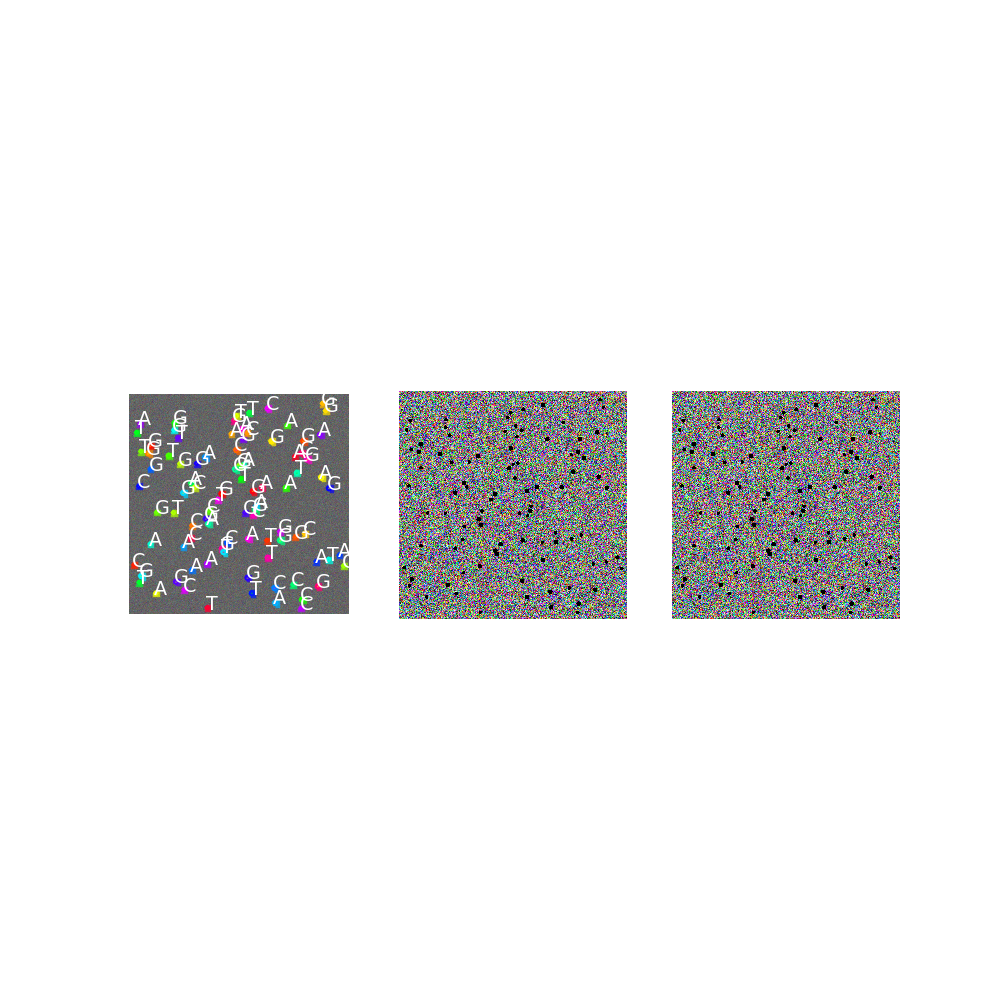

In [12]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [14]:
gt_class_id

array([2, 3, 4, 4, 2, 2, 3, 2, 4, 3, 3, 4, 2, 3, 4, 4, 4, 3, 2, 1, 2, 2,
       1, 2, 1, 3, 2], dtype=int32)

In [11]:
r['class_ids']

array([], dtype=int32)

In [16]:
# r['rois']

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  float64
image_meta (17,) [  0 512 512   3 512 512   3   0   0 512 512   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


<IPython.core.display.Javascript object>


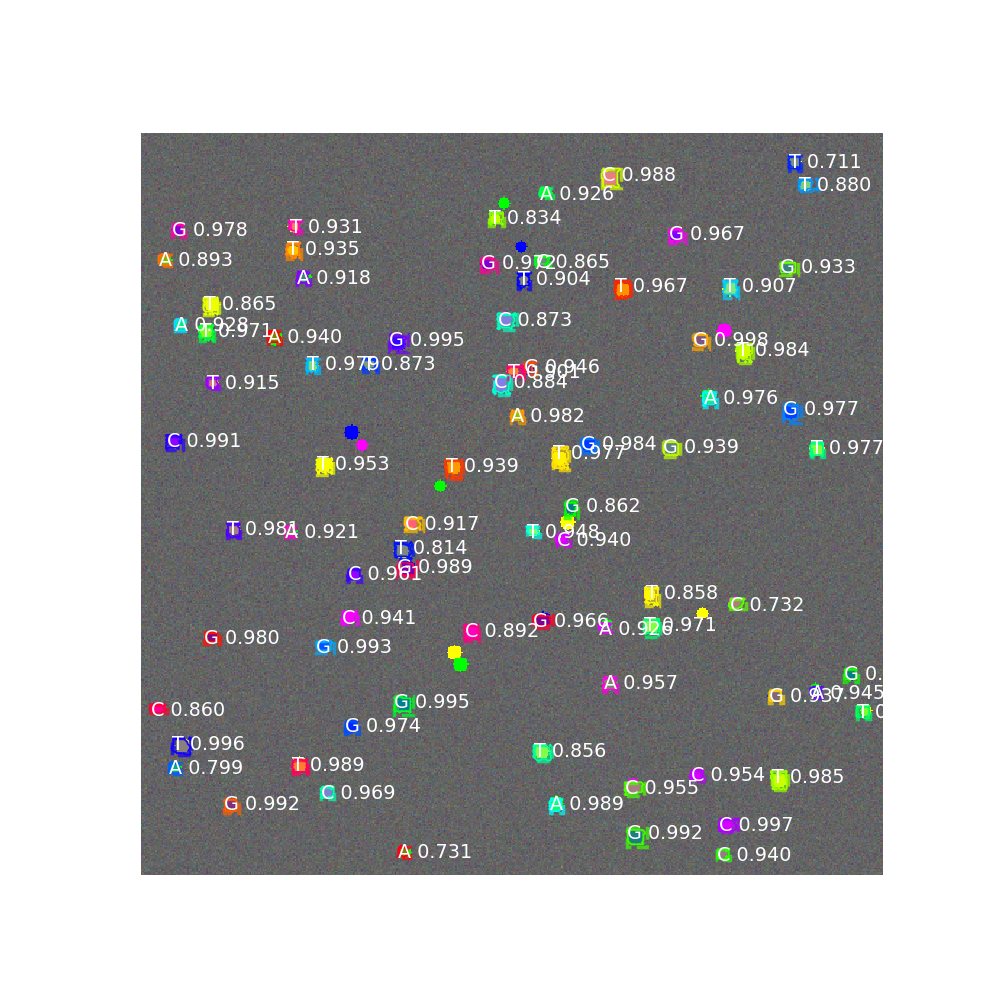

In [11]:
%matplotlib notebook
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [30]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [60]:
# results

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


Dimension(100)

# Clustering details:
- test both of the following, when doing clustering at each iteration:
    - Predict based on random initialization at first at the first iteration, then for the next one instialize clusters based on predictions 
    - At each iteration permute labels so that it has the minimum hamming distance to the predicted ones 

In [ ]:
reassigned_labels=reas_labels3(kmeans.labels_,\
                               pred_labels_arr[forg_index],kmeans.cluster_centers_,feat_arr_forg,nClust-1)